In [1]:
!pip install yfinance
!pip install pmdarima

In [73]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [74]:
btc_ticker = yf.Ticker("BTC-USD")


In [75]:
# Get today's date
end_date = pd.Timestamp.today()

# Calculate the date 10 years ago from today
start_date = end_date - pd.DateOffset(years=10)

# Fetch historical data from Yahoo Finance
btc_ticker = yf.Ticker("BTC-USD")
btc_data = btc_ticker.history(start=start_date, end=end_date)


In [76]:
btc_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-10 00:00:00+00:00,60881.230469,61464.511719,60287.566406,60945.812500,15745822278,0.0,0.0
2024-08-11 00:00:00+00:00,60944.890625,61778.660156,58348.824219,58719.484375,22759754812,0.0,0.0
2024-08-12 00:00:00+00:00,58719.394531,60680.332031,57688.898438,59354.515625,37078637820,0.0,0.0


In [77]:
#dropping other columns 

btc_data= btc_data[["Close"]]

In [78]:
btc_data= btc_data.rename(columns = {"Close": "price"})

In [79]:
# Extract only the date from the index
btc_data.index = btc_data.index.date

In [80]:
btc_data

,price
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2024-08-10,60945.812500
2024-08-11,58719.484375
2024-08-12,59354.515625
2024-08-13,60609.566406


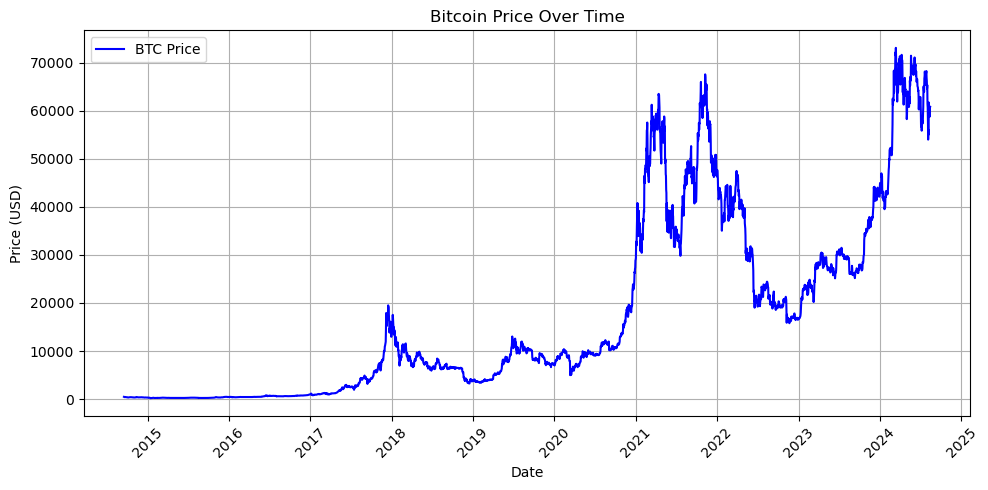

In [81]:
# Plot the graph
plt.figure(figsize=(10, 5))
plt.plot(btc_data.index, btc_data['price'], label='BTC Price', color='blue')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.,
        18993., 19358., 19723., 20089.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

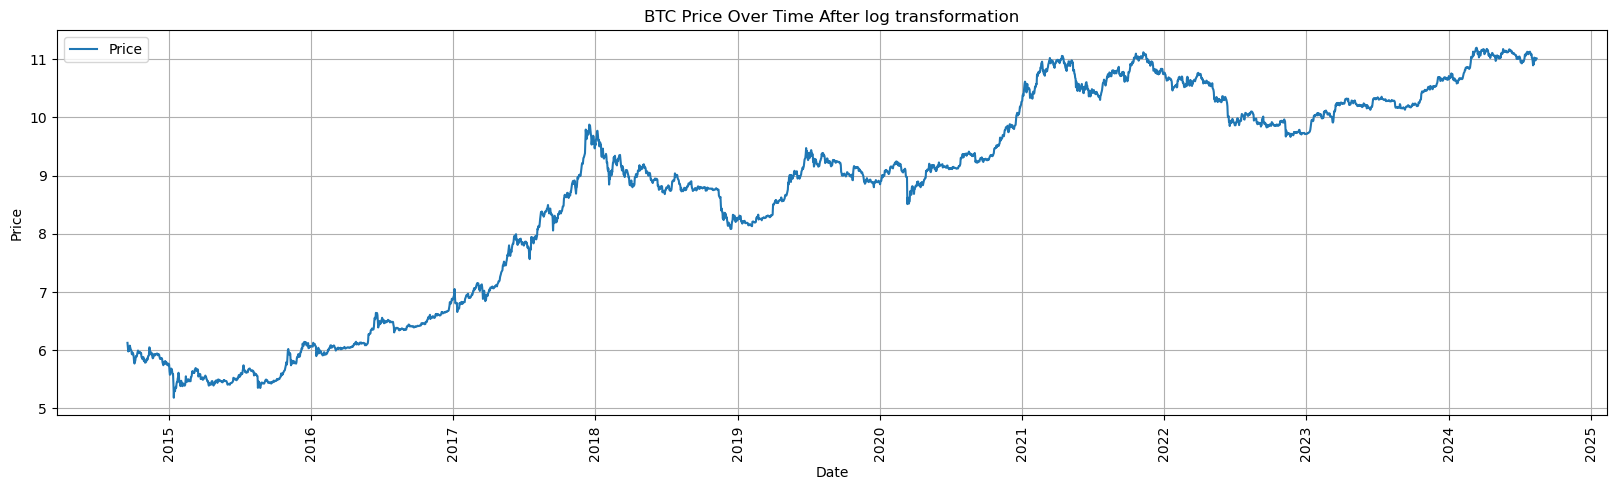

In [82]:
# reduce variance by using log transformation
btc_data['price'] = np.log(btc_data['price'])

plt.figure(figsize=(20, 5))
# plot x and y axis
plt.plot(btc_data.index, btc_data['price'], label='Price')
# set labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Price Over Time After log transformation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)

In [83]:
# This log transformation should help in stabilizing the variance in your Bitcoin price data, making it more suitable for further analysis and modeling.

In [84]:
#perform decomposition to extract trend seasonality and residual 

In [85]:
# Log transform the data to stabilize variance
btc_data['log_price'] = np.log(btc_data['price'])

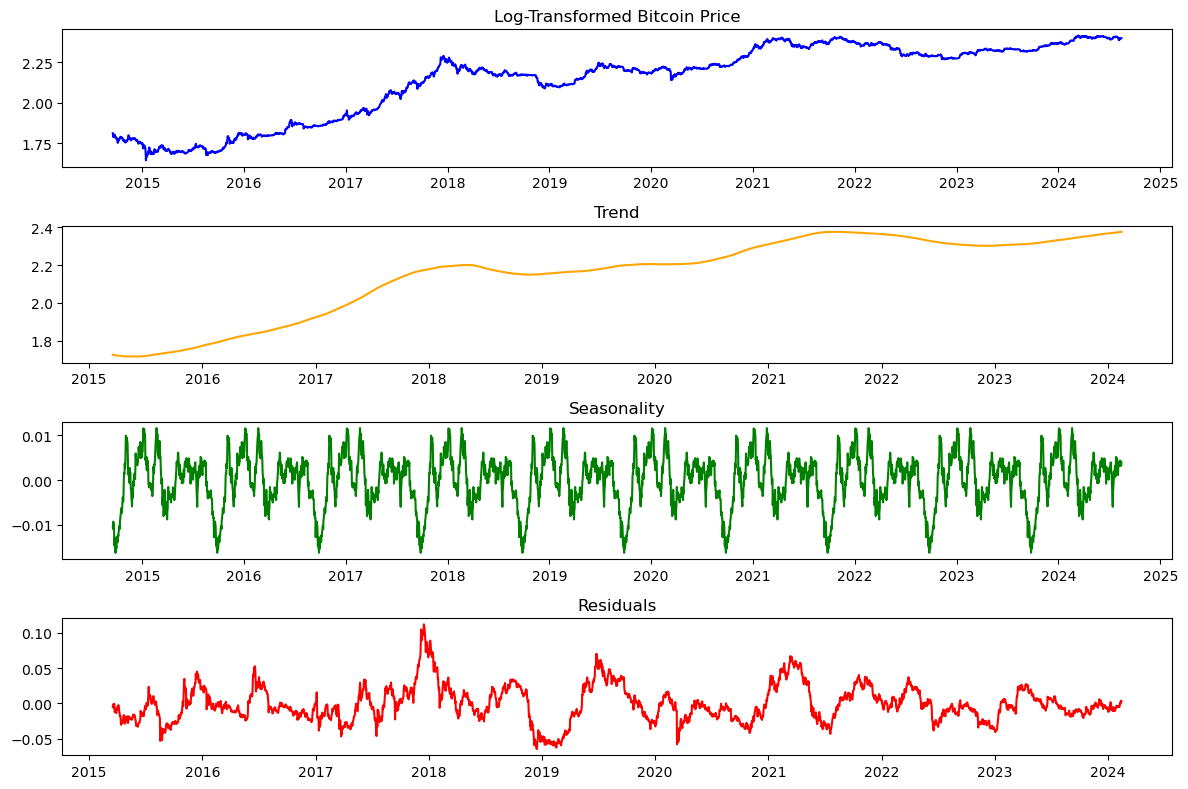

In [86]:
#Perform seasonal decomposition
decomposition = seasonal_decompose(btc_data['log_price'], model='additive', period=365)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(btc_data['log_price'], label='Log-Transformed Price', color='blue')
plt.title('Log-Transformed Bitcoin Price')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.title('Trend')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.title('Seasonality')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.title('Residuals')

plt.tight_layout()
plt.show()

#The residual component in time series analysis refers to the part of the data that remains after the trend and seasonality components have been removed. It's essentially the "leftover" or unexplained variation in the time series, which can't be attributed to the overall trend or recurring seasonal patterns.

#thr are 2 types to check stationarity , Rolling stat and ADCF test

# Check for Stationarity with Dicky fuller test 

In [87]:
# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(btc_data['log_price'])

# Output the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

# Interpretation of the results
if adf_result[1] < 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is not stationary (fail to reject null hypothesis).")

ADF Statistic: -1.095062744315784
p-value: 0.7170368040789181
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567
The time series is not stationary (fail to reject null hypothesis).


# Results Interpretation:

ADF Statistic: A more negative value indicates stronger evidence against the null hypothesis (which states that the series is non-stationary).
p-value: If the p-value is less than a chosen significance level (e.g., 0.05), you can reject the null hypothesis and conclude that the series is stationary.
Critical Values: These are the cutoff values at various significance levels. If the ADF statistic is less than these critical values, the time series is likely stationary.


#Difference the Data (If Not Stationary)
If your Bitcoin price time series data is found to be non-stationary using the Augmented Dickey-Fuller (ADF) test, you can make it stationary by differencing the data. Differencing is a technique that involves subtracting the previous observation from the current observation. This process helps remove trends and seasonality, making the series more stable over time.

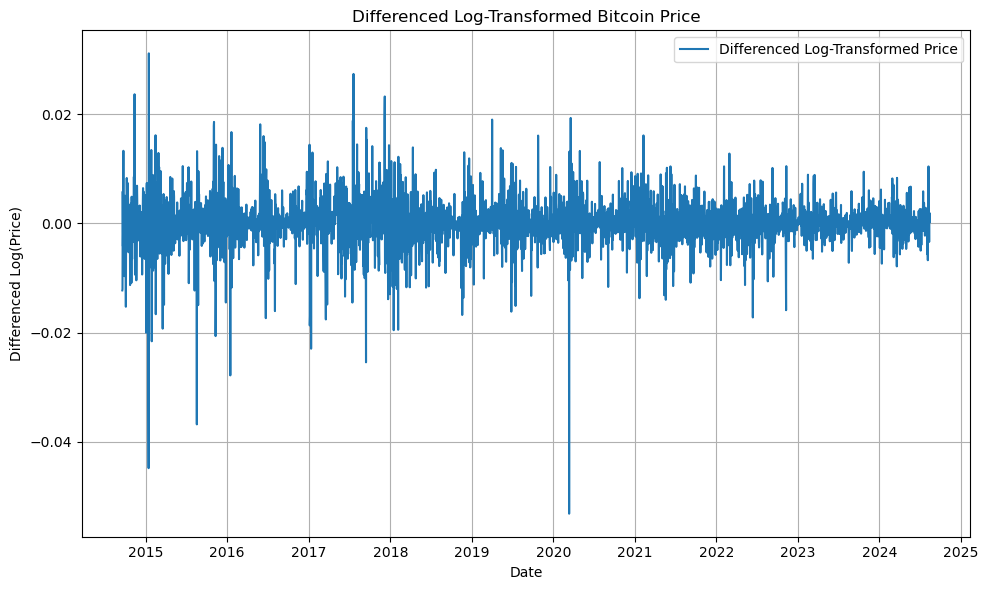

ADF Statistic: -18.710202927555407
p-value: 2.0348939474494855e-30
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567
The differenced time series is stationary (reject null hypothesis).


In [88]:
# Differencing the data
btc_data['log_price_diff'] = btc_data['log_price'].diff().dropna()


# Plot the differenced data
plt.figure(figsize=(10, 6))

plt.plot(btc_data['log_price_diff'], label='Differenced Log-Transformed Price')
plt.title('Differenced Log-Transformed Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Price)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Perform the Augmented Dickey-Fuller test on differenced data
adf_result = adfuller(btc_data['log_price_diff'].dropna())

# Output the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

# Interpretation of the results
if adf_result[1] < 0.05:
    print("The differenced time series is stationary (reject null hypothesis).")
else:
    print("The differenced time series is not stationary (fail to reject null hypothesis).")



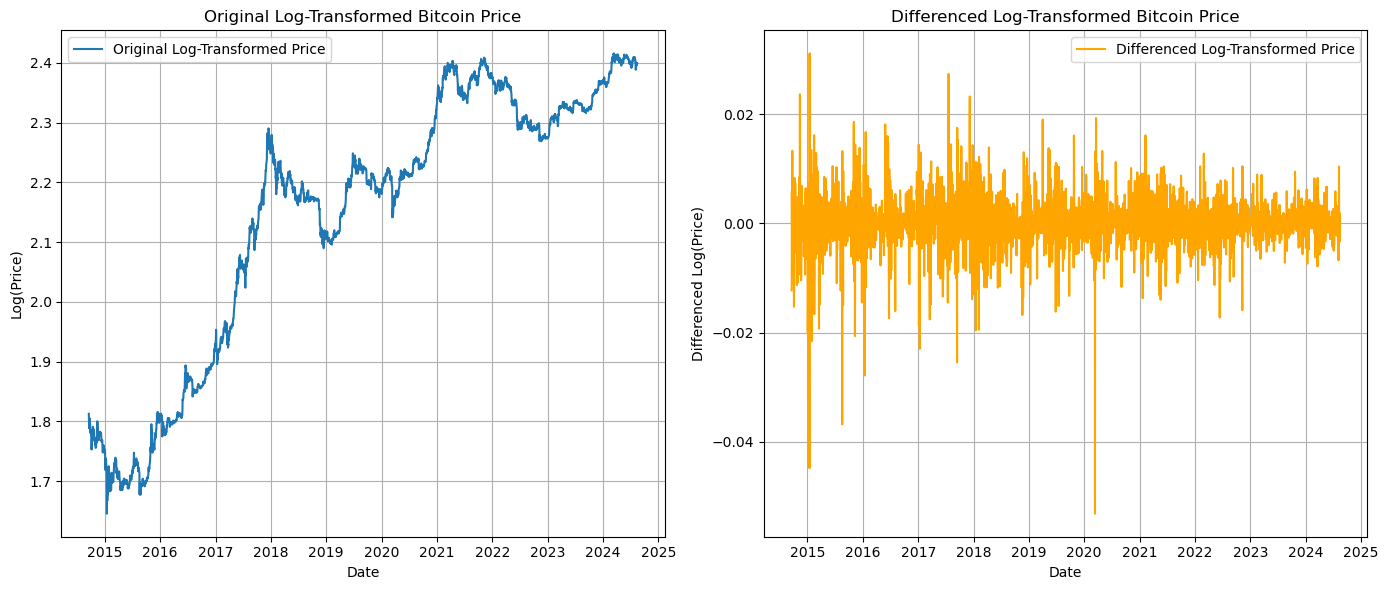

In [89]:

# Plot the original and differenced data side by side
plt.figure(figsize=(14, 6))
# Plot original log-transformed data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(btc_data['log_price'], label='Original Log-Transformed Price')
plt.title('Original Log-Transformed Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Log(Price)')
plt.grid(True)
plt.legend()

# Plot differenced data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(btc_data['log_price_diff'], label='Differenced Log-Transformed Price', color='orange')
plt.title('Differenced Log-Transformed Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Price)')
plt.grid(True)
plt.legend()

plt.tight_layout()  # Adjust spacing between plots
plt.show()

# Using Auto-ARIMA

In [90]:
import pmdarima as pm

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28825.795, Time=2.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28830.584, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28829.682, Time=1.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28829.719, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28827.897, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28827.208, Time=0.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 6.639 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3620
Model:               SARIMAX(0, 1, 0)   Log Likelihood               14417.292
Date:                Wed, 14 Aug 2024   AIC                         -28830.584
Time:                        09:38:38   BIC                         -28818.196
Sample:                    09-17-2014   HQIC                        -28826.17

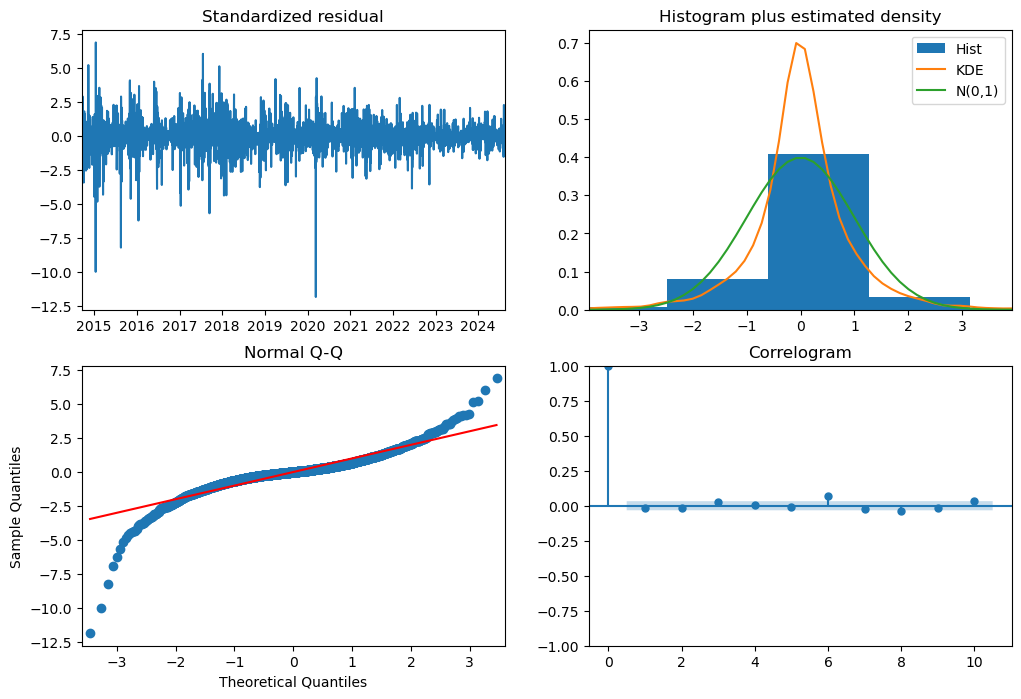

In [91]:
# Use Auto-ARIMA to find the best parameters
auto_arima_model = pm.auto_arima(btc_data['log_price'], 
                                 seasonal=False, 
                                 trace=True, 
                                 error_action='ignore', 
                                 suppress_warnings=True, 
                                 stepwise=True)

# Output the best model parameters
print(auto_arima_model.summary())

# Plot diagnostics of the model
auto_arima_model.plot_diagnostics(figsize=(12, 8))
plt.show()

In [93]:
# Split the data into train and test sets
train_size = int(len(btc_data) * 0.8)
train, test = btc_data['log_price_diff'][:train_size], btc_data['log_price_diff'][train_size:]

In [94]:
# Fit the ARIMA model 0,1,0 (2,0,1)
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit()

C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Test MSE: 8.820786740305104e-06
Test RMSE: 0.002969980932650091
Test R2: -0.4036343387102459


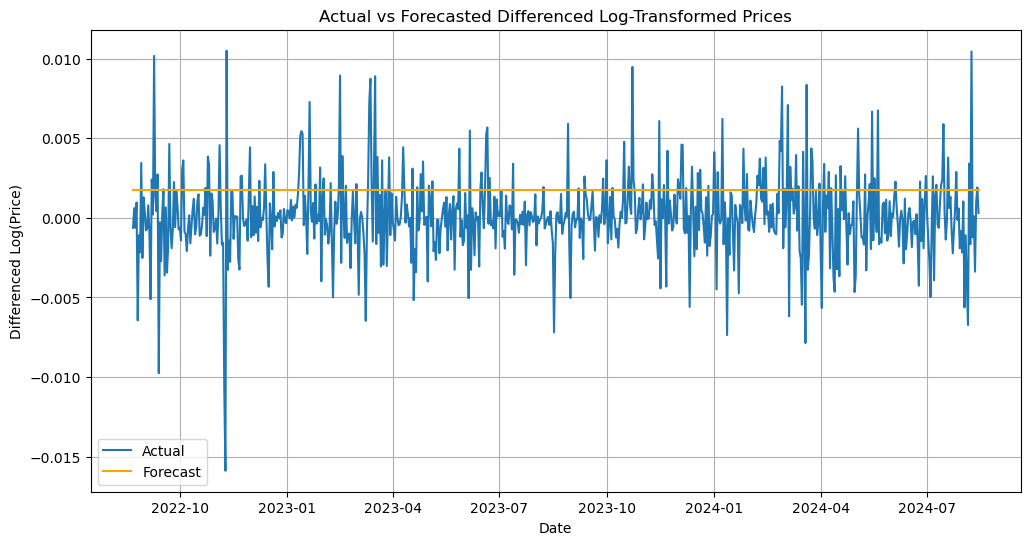

In [95]:
# Forecast the test set
forecast = model_fit.forecast(steps=len(test))

# Ensure forecast and test have the same length
test_len = len(test)
forecast_len = len(forecast)

if test_len != forecast_len:
    min_len = min(test_len, forecast_len)
    test = test[:min_len]
    forecast = forecast[:min_len]

# Calculate the mean squared error
mse = mean_squared_error(test, forecast)  # Aligning lengths
print(f'Test MSE: {mse}')

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse}')

# Calculate the coefficient of determination
r2 = 1 - mse / np.var(test)
print(f'Test R2: {r2}')

# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Actual vs Forecasted Differenced Log-Transformed Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Price)')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
import pmdarima as pm

# Assuming 'price' or 'log_price' is the column you want to model
target_column = btc_data['log_price']  # or btc_data['log_price']

model = pm.auto_arima(target_column,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                      max_p=10,
                      max_q=10,
                      D=0,
                      m=365,  # seasonal period, you can adjust this
                      d=None,
                      test='adf'
                      )

# Print the summary of the model
print(model.summary())

# Get the best parameters
p, d, q = model.order
print(f'Optimal p: {p}, d: {d}, q: {q}')

C:\Users\rupes\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28825.795, Time=2.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28830.584, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28829.682, Time=1.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28829.719, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28827.897, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28827.208, Time=0.85 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 6.413 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3620
Model:               SARIMAX(0, 1, 0)   Log Likelihood               14417.292
Date:                Wed, 14 Aug 2024   AIC                         -28830.584
Time:                        09:42:51   BIC                         -28818.196
Sample:                    09-17-2014   HQIC                        -28826.17

In [115]:
# build arima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(btc_data['price'], order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3620
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6811.319
Date:                Wed, 14 Aug 2024   AIC                         -13620.638
Time:                        09:43:01   BIC                         -13614.444
Sample:                    09-17-2014   HQIC                        -13618.431
                         - 08-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0014   1.24e-05    109.164      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.68   Jarque-Bera (JB):             19585.37
Prob(Q):                              0.19   Pr

C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [116]:
# forescast for next days

forecast_steps = 30
forecast = fitted_model.get_forecast(steps= forecast_steps)

In [117]:
# Ensure the index is a DatetimeIndex
btc_data.index = pd.to_datetime(btc_data.index)

# Create the date range for forecasted values
#forecast_steps = 10  # Example: 10 days into the future
##forecast_index = pd.date_range(start=btc_data.index[-1], periods=forecast_steps+1, freq='D')[1:]
##forecast_index = forecast_index.strftime('%Y-%m-%d')

In [118]:
# create the date range for the forecasted values 
btc_data.index = btc_data.index.map(lambda x: x.strftime('%Y-%m-%d'))
forecast_index = pd.date_range(start=btc_data.index[-1],periods = forecast_steps+1,freq ="D")[1:].strftime("%Y-%m-%d")


In [119]:
#create forecast df
forecast_df = pd.DataFrame({
    "forecast":list(forecast.predicted_mean),
    "Lower_CI":list(forecast.conf_int().iloc[:,0]),
    "Upper_CI":list(forecast.conf_int().iloc[:,1])},index=forecast_index)


forecast_df.tail()

,forecast,Lower_CI,Upper_CI
2024-09-09,11.015554,10.647380,11.383728
2024-09-10,11.015554,10.640367,11.390742
2024-09-11,11.015554,10.633482,11.397627
2024-09-12,11.015554,10.626719,11.404390
2024-09-13,11.015554,10.620072,11.411037


In [120]:
btc_data.index = pd.to_datetime(btc_data.index)
forecast_df.index = pd.to_datetime(forecast_df.index)

In [121]:
# Get the date 365 days ago from the last date in the DataFrame
end_date = btc_data.index[-1]  # Last date in the DataFrame
start_date = end_date - pd.Timedelta(days=365)  # Date 365 days ago

# Slice the DataFrame to get the last 365 days of data
temp_df = btc_data.loc[start_date:end_date]

In [122]:
# plot the forecast values and revert back to original values using np.exp() to convert the log-transformed forecasted values back to the original scale.

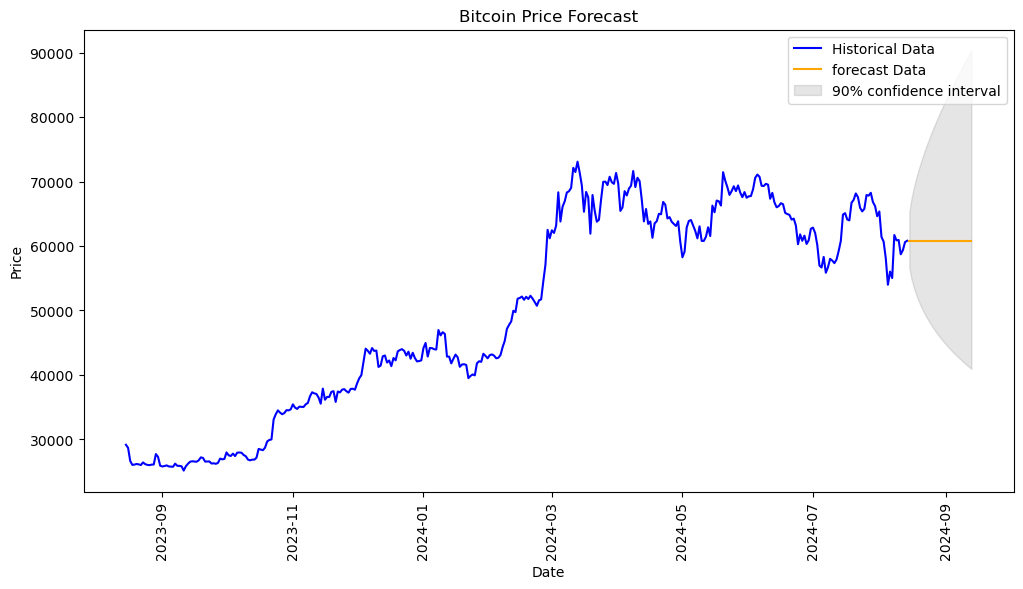

In [113]:
# plot the forecast values and revert back to original values using np.exp()

plt.figure(figsize =(12,6))

#historical data
plt.plot(temp_df.index, np.exp(temp_df["price"]),label ="Historical Data", color="blue")

#forecast data

plt.plot(forecast_df.index, np.exp(forecast_df["forecast"]),label ="forecast Data", color="orange")

#fill between the confidence intervels
plt.fill_between(forecast_df.index,
                 np.exp(forecast_df["Lower_CI"]),
                 np.exp(forecast_df["Upper_CI"]),
                 color="k", alpha=0.1, label="90% confidence interval")
# customise plot
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Bitcoin Price Forecast")
plt.xticks(rotation=90)
plt.legend()

#show plot
plt.show()



In [34]:
# Code for Hybrid Model:

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [123]:
btc_data

,price,log_price,log_price_diff
2014-09-17,6.125414,1.812446,NaN
2014-09-18,6.050771,1.800186,-0.012261
2014-09-19,5.978369,1.788148,-0.012038
2014-09-20,6.013480,1.794004,0.005856
2014-09-21,5.988513,1.789843,-0.004161
...,...,...,...
2024-08-10,11.017740,2.399507,0.000098
2024-08-11,10.980527,2.396123,-0.003383
2024-08-12,10.991283,2.397103,0.000979
2024-08-13,11.012208,2.399004,0.001902


In [36]:
!pip install tensorflow

In [124]:
btc_data

,price,log_price,log_price_diff
2014-09-17,6.125414,1.812446,NaN
2014-09-18,6.050771,1.800186,-0.012261
2014-09-19,5.978369,1.788148,-0.012038
2014-09-20,6.013480,1.794004,0.005856
2014-09-21,5.988513,1.789843,-0.004161
...,...,...,...
2024-08-10,11.017740,2.399507,0.000098
2024-08-11,10.980527,2.396123,-0.003383
2024-08-12,10.991283,2.397103,0.000979
2024-08-13,11.012208,2.399004,0.001902


#
# Code for LSTM: Long Short-Term Memory (LSTM) 

In [38]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

In [39]:
btc_data.isna().sum()

price             0
log_price         0
log_price_diff    1
dtype: int64

In [125]:
btc_data.dropna(inplace=True)

In [126]:
btc_data

,price,log_price,log_price_diff
2014-09-18,6.050771,1.800186,-0.012261
2014-09-19,5.978369,1.788148,-0.012038
2014-09-20,6.013480,1.794004,0.005856
2014-09-21,5.988513,1.789843,-0.004161
2014-09-22,5.996830,1.791231,0.001388
...,...,...,...
2024-08-10,11.017740,2.399507,0.000098
2024-08-11,10.980527,2.396123,-0.003383
2024-08-12,10.991283,2.397103,0.000979
2024-08-13,11.012208,2.399004,0.001902


In [130]:
# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(btc_data[['log_price']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

seq_length = 20  # Try a larger sequence length
X, y = create_sequences(scaled_data, seq_length)

# Define LSTM model with Dropout and more units
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile model with a custom learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Forecast and evaluate
forecast_nn = model.predict(X_test)
forecast_nn = scaler.inverse_transform(forecast_nn)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_nn = mean_squared_error(y_test, forecast_nn)
r2_nn = r2_score(y_test, forecast_nn)

print(f'Test MSE (NN): {mse_nn}')
print(f'Test RMSE (NN): {np.sqrt(mse_nn)}')
print(f'Test R² (NN): {r2_nn}')

Epoch 1/50


C:\Users\rupes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0798 - val_loss: 6.5714e-04
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0036 - val_loss: 1.9471e-04
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0033 - val_loss: 8.7884e-05
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0028 - val_loss: 1.7681e-04
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0028 - val_loss: 1.3994e-04
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0029 - val_loss: 7.7190e-04
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0025 - val_loss: 9.4833e-04
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0022 - val_loss: 3.0323e-04
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s

# Time Series Cross-Validation

In [128]:
btc_data_reset = btc_data.reset_index()
btc_data_reset.rename(columns={'index': 'Date'}, inplace=True)

In [129]:
btc_data_reset

,Date,price,log_price,log_price_diff
0,2014-09-18,6.050771,1.800186,-0.012261
1,2014-09-19,5.978369,1.788148,-0.012038
2,2014-09-20,6.013480,1.794004,0.005856
3,2014-09-21,5.988513,1.789843,-0.004161
4,2014-09-22,5.996830,1.791231,0.001388
...,...,...,...,...
3614,2024-08-10,11.017740,2.399507,0.000098
3615,2024-08-11,10.980527,2.396123,-0.003383
3616,2024-08-12,10.991283,2.397103,0.000979
3617,2024-08-13,11.012208,2.399004,0.001902


In [135]:
btc_data_reset = btc_data_reset.reset_index()

# Now you can access the 'Date' column
X = btc_data_reset[["log_price"]].values  # Features
y = btc_data_reset['price'].values   # Target

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits

# Initialize a model (Random Forest for this example)
model = RandomForestRegressor(n_estimators=100)

# Lists to store performance metrics
r2_scores = []
mse_scores = []

for train_index, test_index in tscv.split(X):
    # Split data into train and test based on the current split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the testing data
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Print the performance metrics
print(f'Average R²: {np.mean(r2_scores)}')
print(f'Average MSE: {np.mean(mse_scores)}')

Average R²: 0.42033719277239856
Average MSE: 0.5321875526929889


Average R²: 0.4202676350329549
Average MSE: 0.5322739775117283


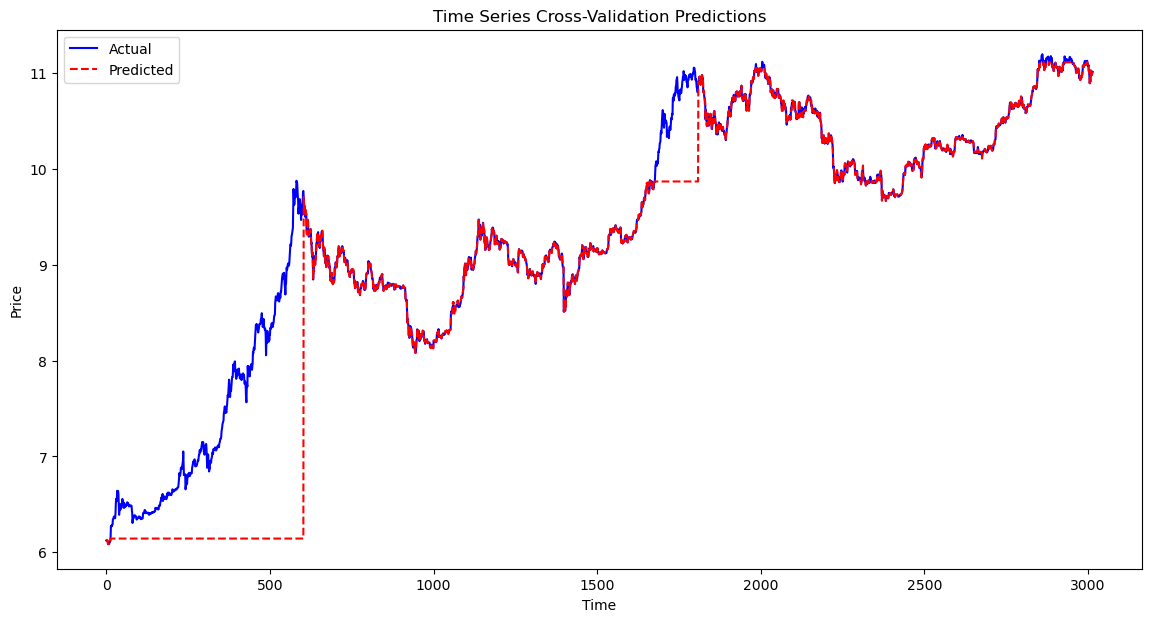

Predictions for the next 30 days:
[11.01551157 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157
 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157
 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157
 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157
 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157 11.01551157]


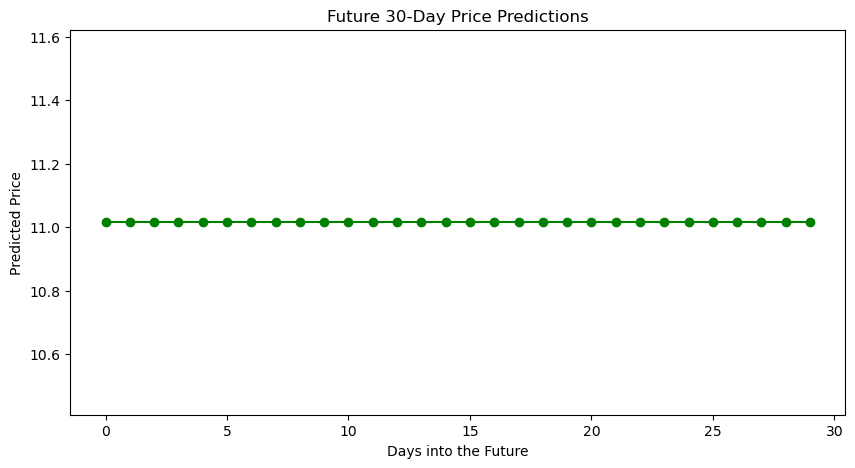

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Reset the index and drop the old index column
if 'level_0' in btc_data_reset.columns:
    btc_data_reset = btc_data_reset.drop(columns=['level_0'])


# Extract features and target
X = btc_data_reset[["log_price"]].values  # Features
y = btc_data_reset['price'].values        # Target

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Initialize a model (Random Forest in this case)
model = RandomForestRegressor(n_estimators=100)

# Lists to store performance metrics and predictions
r2_scores = []
mse_scores = []
predictions = []
actuals = []

# Time Series Cross-Validation
for train_index, test_index in tscv.split(X):
    # Split data into train and test based on the current split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the testing data
    y_pred = model.predict(X_test)
    
    # Store predictions and actual values for plotting
    predictions.extend(y_pred)
    actuals.extend(y_test)
    
    # Calculate performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Print the performance metrics
print(f'Average R²: {np.mean(r2_scores)}')
print(f'Average MSE: {np.mean(mse_scores)}')

# Plot the TSCV predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(actuals, color='blue', label='Actual')
plt.plot(predictions, color='red', linestyle='--', label='Predicted')
plt.title('Time Series Cross-Validation Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Train the model on the entire dataset to predict the next 30 days
model.fit(X, y)

# Prepare the feature set for the next 30 days (e.g., extending log_price)
# For this example, we'll use the last available log_price as a simple approach
last_log_price = X[-1][0]
future_X = np.array([last_log_price for _ in range(30)]).reshape(-1, 1)

# Predict the next 30 days
future_predictions = model.predict(future_X)

# Output the predictions
print("Predictions for the next 30 days:")
print(future_predictions)

# Plot the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_predictions, marker='o', linestyle='-', color='green')
plt.title('Future 30-Day Price Predictions')
plt.xlabel('Days into the Future')
plt.ylabel('Predicted Price')
plt.show()

# Out-of-Sample Backtesting

In [54]:
#btc_data_reset = btc_data.reset_index()
#btc_data_reset.rename(columns={'index': 'Date'}, inplace=True)

In [55]:
#btc_data_reset

C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


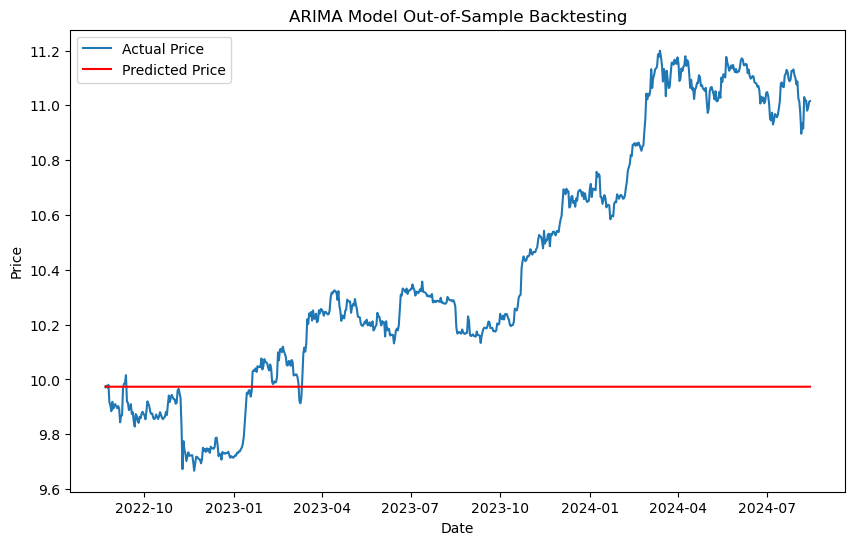

Test MSE: 0.3964159178785383
Test RMSE: 0.6296156906228897
Test R²: -0.8891393440016713


In [132]:
btc_data_reset['Date'] = pd.to_datetime(btc_data_reset['Date'])
btc_data_reset.set_index('Date', inplace=True)

# Split data into training and testing sets
train_size = int(len(btc_data_reset) * 0.8)  # 80% for training, 20% for testing
train, test = btc_data_reset.iloc[:train_size], btc_data_reset.iloc[train_size:]

# Train ARIMA model
arima_model = ARIMA(train['price'], order=(5, 1, 0))  # Example ARIMA order
arima_fit = arima_model.fit()

# Forecast on the test set
start_index = test.index[0]
end_index = test.index[-1]
arima_forecast = arima_fit.predict(start=start_index, end=end_index, typ='levels')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test['price'], label='Actual Price')
plt.plot(arima_forecast, label='Predicted Price', color='red')
plt.title('ARIMA Model Out-of-Sample Backtesting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(test['price'], arima_forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test['price'], arima_forecast)

print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test R²: {r2}')

In [133]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

C:\Users\rupes\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
